# Feature selection on the dataset

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df_final = pd.read_csv("data.csv")
df = df_final.sample(frac=0.5)
df_reduced = df_final.sample(frac=0.1)

In [ ]:
df.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN6,OPN7,OPN8,OPN9,OPN10,extroversion,agreeableness,conscientiousness,neuroticism,openness_to_experience
158254,1.0,3.0,5.0,5.0,3.0,2.0,1.0,5.0,1.0,5.0,...,1.0,1.0,5.0,5.0,5.0,31.0,23.0,34.0,25.0,32.0
32470,1.0,5.0,1.0,5.0,1.0,5.0,1.0,5.0,1.0,5.0,...,2.0,4.0,3.0,4.0,4.0,30.0,37.0,41.0,34.0,34.0
402516,5.0,3.0,5.0,1.0,5.0,1.0,5.0,5.0,5.0,3.0,...,1.0,5.0,3.0,1.0,5.0,38.0,40.0,38.0,22.0,27.0
318748,1.0,4.0,4.0,3.0,1.0,5.0,1.0,5.0,2.0,5.0,...,2.0,5.0,3.0,4.0,3.0,31.0,30.0,32.0,27.0,32.0
384049,4.0,1.0,4.0,1.0,4.0,2.0,4.0,2.0,5.0,1.0,...,4.0,3.0,1.0,3.0,0.0,28.0,30.0,26.0,17.0,25.0


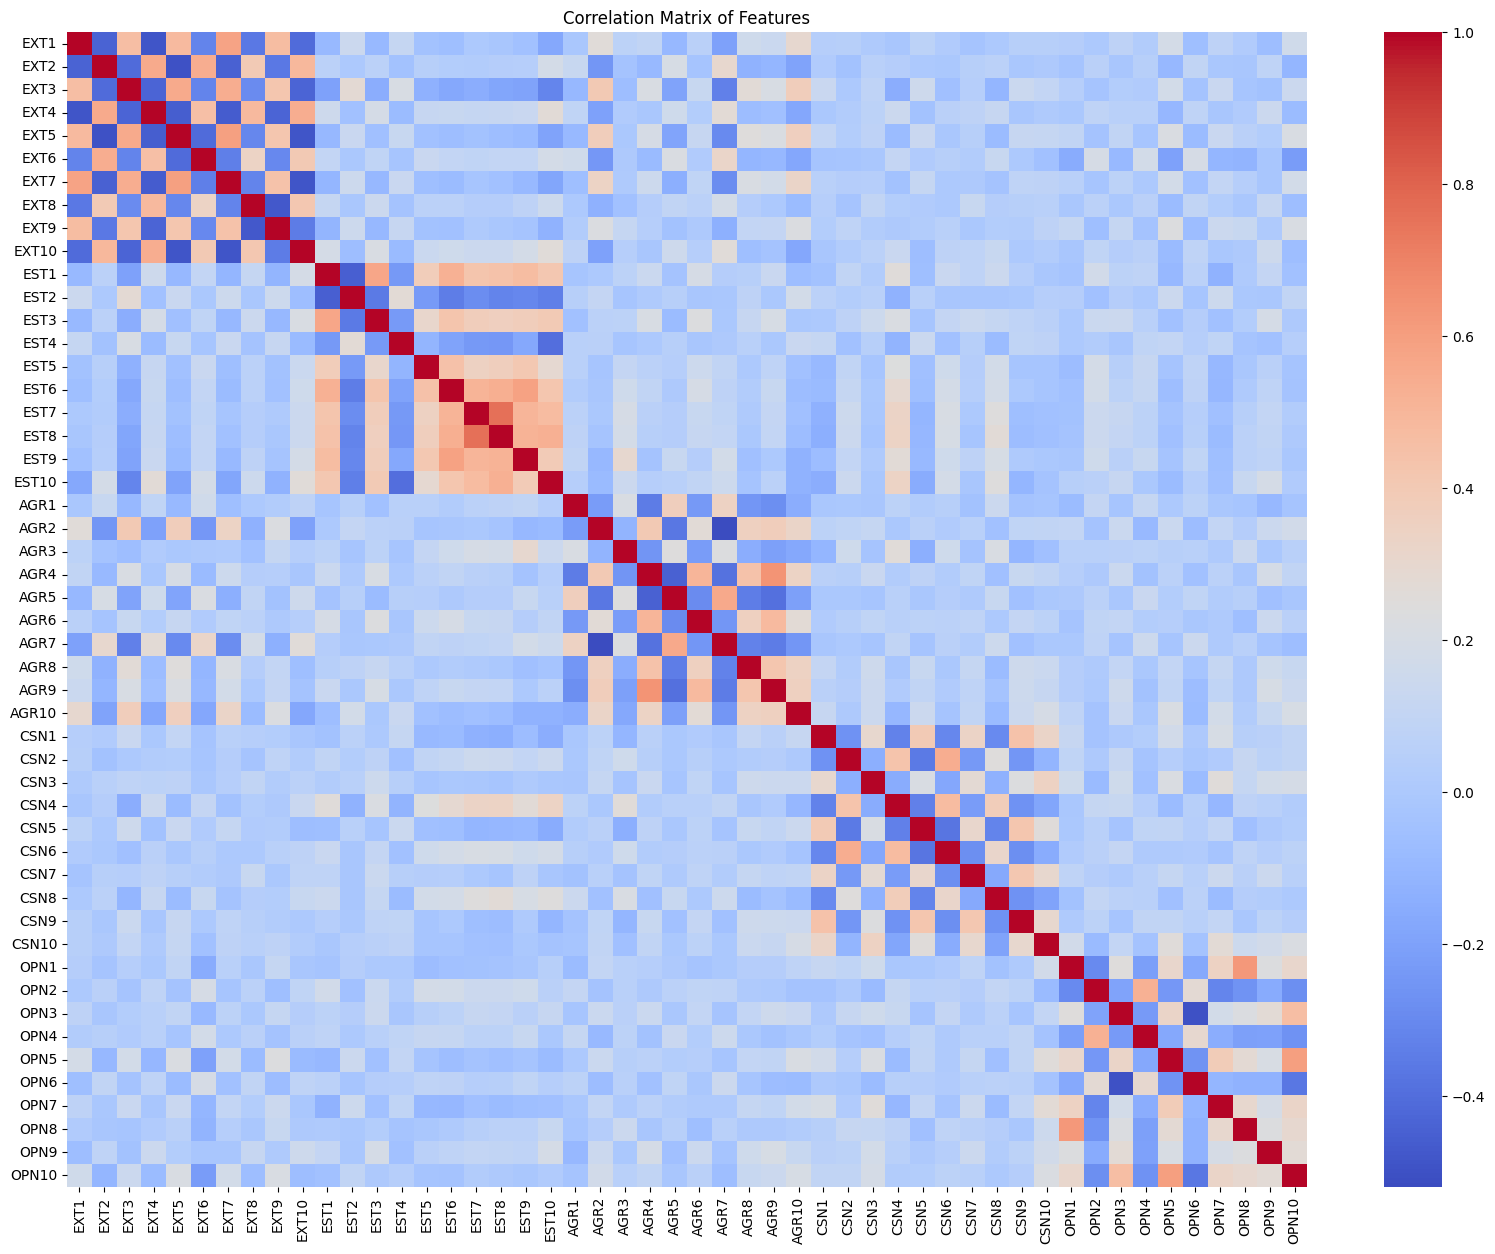

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix of the features
corr_matrix = df.iloc[:, :50].corr()

# Plotting the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix of Features")
plt.show()


In [ ]:
#Remove highly correlated features

# Identifying highly correlated features
high_corr = set()
correlation_threshold = 0.8

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
            colname = corr_matrix.columns[i]
            high_corr.add(colname)

# Removing the highly correlated features
df_reduced = df.drop(columns=high_corr)

# Displaying the remaining features after removing highly correlated ones
remaining_features = df_reduced.columns[:50-len(high_corr)]  # Assuming first 50 are features
len(remaining_features), remaining_features.tolist()


(50,
 ['EXT1',
  'EXT2',
  'EXT3',
  'EXT4',
  'EXT5',
  'EXT6',
  'EXT7',
  'EXT8',
  'EXT9',
  'EXT10',
  'EST1',
  'EST2',
  'EST3',
  'EST4',
  'EST5',
  'EST6',
  'EST7',
  'EST8',
  'EST9',
  'EST10',
  'AGR1',
  'AGR2',
  'AGR3',
  'AGR4',
  'AGR5',
  'AGR6',
  'AGR7',
  'AGR8',
  'AGR9',
  'AGR10',
  'CSN1',
  'CSN2',
  'CSN3',
  'CSN4',
  'CSN5',
  'CSN6',
  'CSN7',
  'CSN8',
  'CSN9',
  'CSN10',
  'OPN1',
  'OPN2',
  'OPN3',
  'OPN4',
  'OPN5',
  'OPN6',
  'OPN7',
  'OPN8',
  'OPN9',
  'OPN10'])

In [ ]:
#SelectKBest method with the ANOVA F-value
from sklearn.feature_selection import SelectKBest, f_classif

#How many feature per objective variable
k = 5

# Function to select top K features for each target variable
def select_features(X, y, k=5):
    fs = SelectKBest(score_func=f_classif, k=k)
    fs.fit(X, y)
    return fs

# Features and targets
X = df.iloc[:, :50]
targets = df.columns[-5:]

# Selecting top 10 features for each target
selected_features = {}
for target in targets:
    y = df[target]
    fs = select_features(X, y, k)
    selected_features[target] = X.columns[fs.get_support()].tolist()

print(selected_features)

# Combining the most important features from each target into one list
kbest_features = set()
for features in selected_features.values():
    kbest_features.update(features)

# Converting to a list
kbest_features = list(kbest_features)
print(kbest_features)



{'extroversion': ['EXT1', 'EXT3', 'EXT5', 'EXT6', 'EXT7'], 'agreeableness': ['AGR4', 'AGR6', 'AGR8', 'AGR9', 'AGR10'], 'conscientiousness': ['CSN1', 'CSN3', 'CSN7', 'CSN9', 'CSN10'], 'neuroticism': ['EST1', 'EST6', 'EST7', 'EST8', 'EST9'], 'openness_to_experience': ['OPN1', 'OPN5', 'OPN7', 'OPN8', 'OPN10']}
['EXT6', 'EXT3', 'CSN7', 'AGR4', 'EST1', 'EST6', 'OPN5', 'OPN7', 'EXT5', 'CSN3', 'OPN10', 'AGR6', 'CSN1', 'EST8', 'CSN10', 'AGR8', 'OPN1', 'EST7', 'CSN9', 'EST9', 'AGR10', 'AGR9', 'EXT7', 'OPN8', 'EXT1']


In [ ]:
#Recursive feature elimination

from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet

# Function to perform RFE
def apply_rfe(X, y, n_features_to_select=5):
    #model = RandomForestRegressor(n_estimators=10)
    model = ElasticNet(alpha=1.0, l1_ratio=0.5)
    #rfecv = RFECV(estimator=model, n_features_to_select=n_features_to_select ,step=1, cv=KFold(5), scoring='neg_mean_squared_error')
    rfe = RFE(model, n_features_to_select=n_features_to_select)
    rfe = rfe.fit(X, y)
    return X.columns[rfe.get_support()]


# Since we have multiple targets, we should perform RFE for each target separately
rfe_selected_features = {}
# Features and targets
X = df_reduced.iloc[:, :50]
y = df_reduced.iloc[:, 50:]

for target in y.columns:
    # Applying RFE for the current target
    selected_features = apply_rfe(X, df[target])
    rfe_selected_features[target] = selected_features

print(rfe_selected_features)

# Combining all the selected features into a single set to remove duplicates
rfe_features = set()
for features in rfe_selected_features.values():
    rfe_features.update(features)

# Converting to a list
rfe_features = list(rfe_features)
print(rfe_features)


{'extroversion': Index(['EXT2', 'EXT3', 'EXT6', 'EXT7', 'EXT8'], dtype='object'), 'agreeableness': Index(['AGR1', 'AGR6', 'AGR8', 'AGR9', 'AGR10'], dtype='object'), 'conscientiousness': Index(['CSN3', 'CSN6', 'CSN7', 'CSN9', 'CSN10'], dtype='object'), 'neuroticism': Index(['EST1', 'EST6', 'EST7', 'EST8', 'EST9'], dtype='object'), 'openness_to_experience': Index(['OPN1', 'OPN5', 'OPN8', 'OPN9', 'OPN10'], dtype='object')}
['EXT6', 'EXT3', 'CSN6', 'EXT2', 'CSN7', 'EST1', 'EST6', 'OPN5', 'OPN10', 'CSN3', 'AGR6', 'EST8', 'CSN10', 'AGR8', 'OPN1', 'AGR1', 'EST7', 'CSN9', 'OPN9', 'EXT8', 'EST9', 'AGR10', 'AGR9', 'EXT7', 'OPN8']


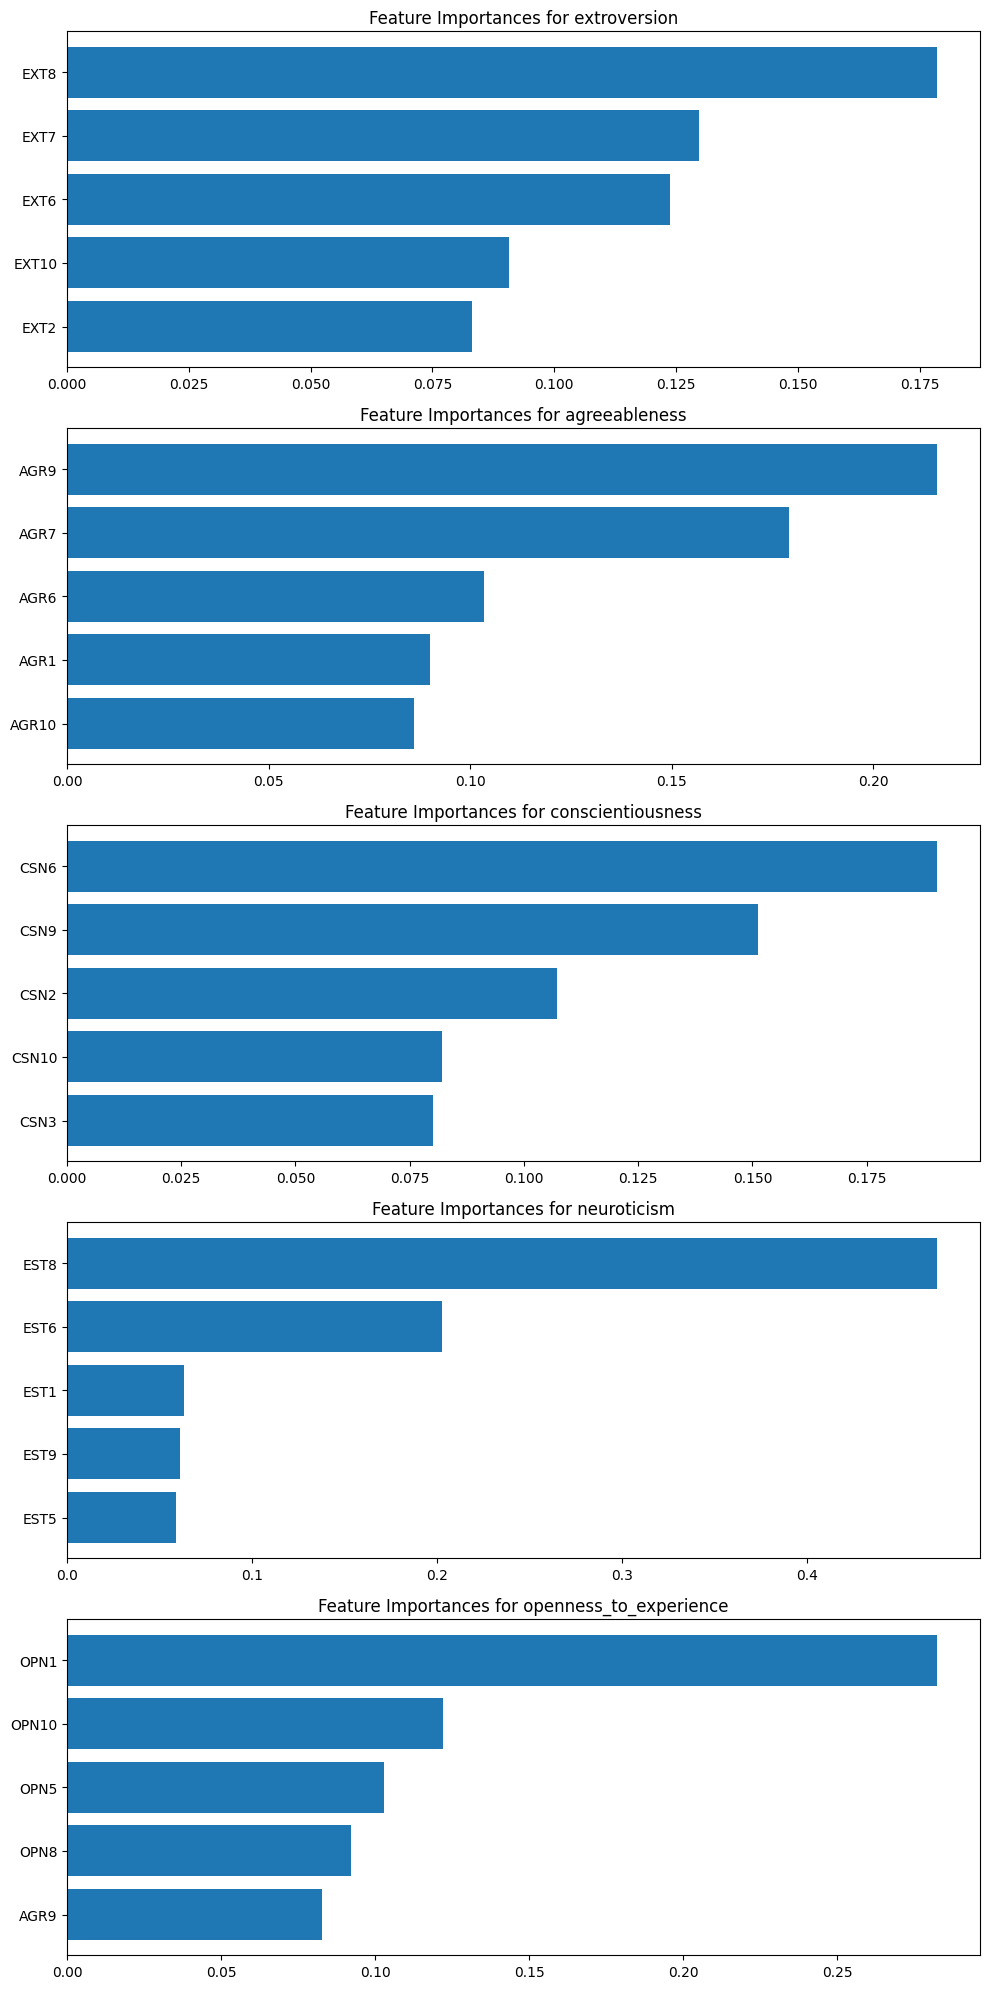

['EXT6', 'CSN6', 'EXT2', 'AGR7', 'EST1', 'EST6', 'OPN5', 'OPN10', 'CSN3', 'CSN2', 'AGR6', 'EXT10', 'EST8', 'CSN10', 'OPN1', 'AGR1', 'CSN9', 'EST5', 'EST9', 'EXT8', 'AGR10', 'AGR9', 'EXT7', 'OPN8']


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Reducing the number of trees in the Random Forest model to decrease computational time
model = RandomForestRegressor(n_estimators=10)  # Using only 10 trees

# Dictionary to store the top 10 features for each target
top_10_features_per_target = {}

# Plotting feature importances for each target variable
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
for i, target in enumerate(df.columns[50:]):
    y_target = df[target]
    model.fit(X, y_target)
    importances = model.feature_importances_
    indices = np.argsort(importances)[-5:]  # Top 10 features

    # Store the top 10 features for each target
    top_10_features_per_target[target] = X.columns[indices].tolist()

    # Plot
    axes[i].barh(range(5), importances[indices], align='center')
    axes[i].set_yticks(range(5))
    axes[i].set_yticklabels(X.columns[indices])
    axes[i].set_title(f'Feature Importances for {target}')

plt.tight_layout()
plt.show()

top_10_features_per_target

important_features = set()
for features in top_10_features_per_target.values():
    important_features.update(features)

print(list(important_features))




In [ ]:
#Mixed the final reduced dataset

# Convert the lists to sets
set1 = set(kbest_features)
set2 = set(rfe_features)
set3 = set(important_features)

# Find the intersection (common elements) of the three sets
common_features = set1.intersection(set2, set3)
print(len(common_features))

# Convert to list (if needed)
common_features_list = list(common_features)

# Add the objective variable columns to the list
final_columns = common_features_list + ['extroversion', 'agreeableness', 'conscientiousness', 'neuroticism', 'openness_to_experience']

# Filter the DataFrame to include only the selected columns
filtered_df = df_final[final_columns]

# Displaying the first few rows of the filtered DataFrame
filtered_df.head()

filtered_df.to_csv('data-filtered.csv', index=False)

16
